In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, brier_score_loss
from catboost import CatBoostRegressor 
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
import shap

In [ ]:
# !pip install catboost
# !pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/AML_Final_report')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MODEL could deal with text data: catboost, lightgbm

In [ ]:
train= pd.read_csv('processed_train_without_ohe.csv')
test = pd.read_csv('processed_test_without_ohe.csv')

y = pd.read_csv('label_train.csv')
y = y.squeeze()
cat_cols = ['original_language','status','weekday','day','month']

In [ ]:
train.original_language = train.original_language.astype('category')
train.status = train.status.astype('category')
train.weekday = train.weekday.fillna(train.weekday.value_counts().index[0]).astype(int).astype('category')
train.day = train.day.fillna(train.day.value_counts().index[0]).astype(int).astype('category')
train.month = train.month.fillna(train.month.value_counts().index[0]).astype(int).astype('category')

test.original_language = test.original_language.astype('category')
test.status = test.status.fillna('Rumored')
test.status = test.status.astype('category')
test.weekday = test.weekday.fillna(test.weekday.value_counts().index[0]).astype(int).astype('category')
test.day = test.day.fillna(test.day.value_counts().index[0]).astype(int).astype('category')
test.month = test.month.fillna(test.month.value_counts().index[0]).astype(int).astype('category')

In [ ]:
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

In [ ]:
preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

In [ ]:
def model_train(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [ ]:
def submission(preds_test):
    final_preds = preds_test.mean(axis=1)
    sub = pd.read_csv('sample_submission.csv')
    sub.revenue = np.exp(final_preds)
    sub.to_csv('sub_hist.csv',index=False)
    return final_preds,sub

Lightgbm without tune

In [ ]:
lgb_m = lgb.LGBMRegressor()
pred_test_lgb,log_rmse_train_lgb,log_rmse_val_lgb = model_train(lgb_m)
print('train score:',np.mean(log_rmse_train_lgb), 'validation score:',np.mean(log_rmse_val_lgb))
result = submission(pred_test_lgb)[0]

100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

train score: 1.0059796329747979 validation score: 2.133742315498701


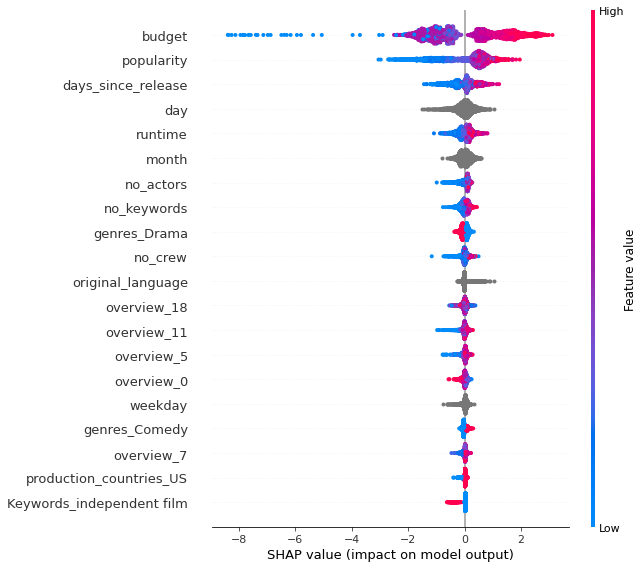

In [ ]:
explainer = shap.TreeExplainer(lgb_m)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

In [ ]:
def model_cat(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train,cat_features = cat_cols)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [ ]:
cat = CatBoostRegressor()
pred_test_cat,log_rmse_train_cat,log_rmse_val_cat = model_cat(cat)
print('train score:',np.mean(log_rmse_train_cat), 'validation score:',np.mean(log_rmse_val_cat))
result = submission(pred_test_cat)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
explainer = shap.TreeExplainer(cat)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

In [ ]:
lgb_t = lgb.LGBMRegressor(learning_rate = 0.001,n_estimators = 200 ,max_depth = 10)

In [ ]:
pred_test_t,log_rmse_train_t,log_rmse_val_t = model_train(lgb_t)
print('train score:',np.mean(log_rmse_train_t), 'validation score:',np.mean(log_rmse_val_t))
result = submission(pred_test_t)[0]

In [ ]:
def model_cat(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train,cat_features = cat_cols)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [ ]:
pred_test_cat,log_rmse_train_cat,log_rmse_val_cat = model_cat(cat)
print('train score:',log_rmse_train_cat,'validation score:',log_rmse_val_cat)
result = submission(pred_test_cat)[0]

In [ ]:
# pred_test_cat_tune,log_rmse_train_cat_tune,log_rmse_val_cat_tune = model_cat(pipe_cat)
# print(np.mean(log_rmse_train_cat_tune),np.mean(log_rmse_val_cat_tune))
# result = submission(pred_test_cat_tune)[0]

MODEL could not deal with text data(i.e.: need one-hot encoding)

In [ ]:
train= pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')
train = train.drop(columns=['Unnamed: 0'])
test = test.drop(columns=['Unnamed: 0'])
y = pd.read_csv('label_train.csv')
y = y.squeeze()
test.fillna(test.mode().iloc[0], inplace = True) #fill in missing value with mode
cat_cols = ['original_language','status','weekday','day','month']

In [ ]:
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

In [ ]:
preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

In [ ]:
def model_train(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [ ]:
def submission(preds_test):
    final_preds = preds_test.mean(axis=1)
    sub = pd.read_csv('sample_submission.csv')
    sub.revenue = np.exp(final_preds)
    sub.to_csv('sub_hist.csv',index=False)
    return final_preds,sub

In [ ]:
#train[train.select_dtypes("float64").columns.to_list()] = train[train.select_dtypes("float64").columns.to_list()].apply(lambda x: np.float32(x))

In [ ]:
#test[test.select_dtypes("float64").columns.to_list()] = test[test.select_dtypes("float64").columns.to_list()].apply(lambda x: np.float32(x))

In [ ]:
test.select_dtypes("float64").columns

In [ ]:
test.fillna(test.mode().iloc[0], inplace = True)

In [ ]:
rf = RandomForestRegressor()
pred_test_rf,log_rmse_train_rf,log_rmse_val_rf = model_train(rf)
print('train score:',np.mean(log_rmse_train_rf), 'vali score:',np.mean(log_rmse_val_rf))
result = submission(pred_test_rf)[0]

In [ ]:
explainer = shap.TreeExplainer(rf)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

Hist

In [ ]:
hist = HistGradientBoostingRegressor()
pred_test_hist,log_rmse_train_hist,log_rmse_val_hist = model_train(hist)
print('train score:',np.mean(log_rmse_train_hist),'val score:', np.mean(log_rmse_val_hist))
result = submission(pred_test_hist)[0]

In [ ]:
explainer = shap.TreeExplainer(hist)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

GB

In [ ]:
gb = GradientBoostingRegressor()
pred_test_gb,log_rmse_train_gb,log_rmse_val_gb = model_train(gb)
print('train score:',np.mean(log_rmse_train_gb), 'val score:',np.mean(log_rmse_val_gb))
result = submission(pred_test_gb)[0]

In [ ]:
explainer = shap.TreeExplainer(gb)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

XGB

In [ ]:
xgb = XGBRegressor()
pred_test_xgb,log_rmse_train_xgb,log_rmse_val_xgb = model_train(xgb)
print('train score:',np.mean(log_rmse_train_xgb), 'val score:',np.mean(log_rmse_val_xgb))
result = submission(pred_test_xgb)[0]

In [ ]:
explainer = shap.TreeExplainer(xgb)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)